# The RAG Flow

In [1]:
import os
import json
import math
import time
import random
import re
from typing import List, Tuple, Any

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial.distance import cosine
from dotenv import load_dotenv
import psycopg2
from psycopg2.extras import Json, RealDictCursor
import ast

# LangChain imports
from langchain.schema import BaseRetriever, Document
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

from pydantic import Field

In [2]:
## 1. Setup Environment and Configure Connections

# Load environment variables
load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY") # Get OpenAI API key from environment variables

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, openai_api_key=openai_api_key) #Instantiating a Language Model 
#llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7, openai_api_key=openai_api_key) #Instantiating a Language Model 
#llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=openai_api_key) #Instantiating a Language Model 
#llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.5, openai_api_key=openai_api_key) #Instantiating a Language Model 

embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key) # Create embeddings object using OpenAI's embedding model

# Get PostgreSQL connection details from environment variables
username = os.getenv('PG_ADMIN_USERNAME')  # Get the server admin login name stored in .env file
password = os.getenv('PG_ADMIN_PASSWORD')  # Get the server password stored in .env file
host = os.getenv('PG_SERVER_NAME')         # Get the server name stored in .env file
port = os.getenv('POSTGRES_PORT')          # Get the Standard PostgreSQL port stored in .env file
database = os.getenv('PG_DATABASE')        # Get the database name stored in .env file

# The PostgreSQL connection string 
POSTGRESQL_CONNECTION = f"postgresql://{username}:{password}@{host}:{port}/{database}"

In [3]:
## 2. Define a Custom Document Retrieval Function (PostgresRetriever)  # Help from chatgpt!
# Vector-based retrieval: This uses vector similarity search using the pgvector extension in PostgreSQL.
 
# Custom Retriever class that extends LangChain's BaseRetriever
from scipy.spatial.distance import cosine

class PostgresRetriever(BaseRetriever):
    connection_string: str = Field(...)
    collection_name: str = Field(...)
    embedding_function: Any = Field(...)

    class Config:
        arbitrary_types_allowed = True

    def _get_relevant_documents(self, query: str) -> List[Document]:
        query_embedding = self.embedding_function.embed_query(query)

        with psycopg2.connect(self.connection_string) as conn:
            with conn.cursor(cursor_factory=RealDictCursor) as cur:
                cur.execute(f"""
                    SELECT question_id, question_full, answers, metadata,
                           question_vector <-> %s::vector AS document_distance,
                           answers_vector <-> %s::vector AS answers_distance,
                           question_vector::text as question_vector_text
                    FROM {self.collection_name}
                    ORDER BY question_vector <-> %s::vector
                    LIMIT 20
                """, (json.dumps(query_embedding), json.dumps(query_embedding), json.dumps(query_embedding)))
                results = cur.fetchall()

        all_answers = []
        for result in results:
            metadata = result['metadata']
            answers = result['answers']
            document_relevance = 1 - result['document_distance']
            answers_relevance = 1 - result['answers_distance']
            question_vector = json.loads(result['question_vector_text'])

            for answer in answers:
                answer_text = answer['answer']
                source = answer['source']

                # Assign trust score based on source
                if source == 'AskTheraRAGBuddy':
                    trust_score = 0.5
                elif source == 'Mental Health Dataset':
                    trust_score = 0.75
                else:
                    trust_score = 1.0

                # Combine document relevance, answer relevance, and trust score
                combined_score = (
                    document_relevance * 0.4 +  # Document relevance
                    answers_relevance * 0.4 +   # Answer relevance
                    trust_score * 0.2           # Trust score
                )

                all_answers.append({
                    'question_id': result['question_id'],
                    'question_full': result['question_full'],
                    'answer_text': answer_text,
                    'source': source,
                    'score': combined_score,
                    'metadata': metadata,
                    'question_vector': question_vector  # Add this line
                })

        # Sort answers and select top 10
        sorted_answers = sorted(all_answers, key=lambda x: x['score'], reverse=True)[:10]

        # Create Document objects for the top 10 answers
        documents = []
        for answer in sorted_answers:
            doc = Document(
                page_content=f"Question: {answer['question_full']}\nAnswer: {answer['answer_text']}",
                metadata={
                    'question_id': answer['question_id'],
                    'source': answer['source'],
                    'score': answer['score'],
                    'topic': answer['metadata'].get('topic', ''),
                    'question_title': answer['metadata'].get('question_title', ''),
                    'question_vector': answer['question_vector']  # Use this line
                }
            )
            documents.append(doc)
        return documents
        
    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        return self._get_relevant_documents(query)

# Create an instance of the PostgresRetriever class
postgres_retriever = PostgresRetriever(
    connection_string=POSTGRESQL_CONNECTION,  # PostgreSQL connection string
    collection_name="talk",  # Name of the collection storing documents
    embedding_function=embeddings  # Embedding function to generate query vectors
)


In [4]:
## 3. Custom Prompt Template
# Define a custom prompt template

CUSTOM_PROMPT = PromptTemplate(
    input_variables=["context", "input"],
    template="""
You are an AI assistant tasked with summarizing insights from mental health professionals about mental health related topics and issues.

## Provide an initial response that directly addresses the user's question or concern.
Use insights from the retrieved expert opinions to inform this response.

## After your initial response, provide a comprehensive summary, based only on the retrieved information, that:

## Based on what experts have said on topics relating to [summarized topic]
- [Provide a brief overview of the topic, including its definition and primary characteristics using only the retrieved documents]
- [List key aspects or identifiable features, if applicable. Only include information that is present in the retrieved documents]

## Key points regarding [summarized topic]
- Nature of the concept/issue: [Summarize the fundamental nature]
- Key aspects: [List main aspects or components]
- Related factors: [Summarize related factors or influences, if mentioned]
- Importance/Impact: [Outline the significance or effects]
- Professional perspectives: [Summarize expert views or approaches]

## Consensus among experts
- [Highlight any points of agreement among the experts]

## Specific insights or recommendations mentioned
- [List specific insights, advice, or recommendations given by experts, using bullet points]

Only include information that is present in the retrieved documents. Do not add any information from your own knowledge. 
If any section is not applicable based on the retrieved information, omit it from the summary. Ensure that bullet points are used consistently throughout the response.


Retrieved information:
{context}

User's question: {input}

Your summarized response:
"""
)

# Create the document chain
document_chain = create_stuff_documents_chain(llm, CUSTOM_PROMPT)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PROMPTS THAT WERE TESTED & WERE FOUND LACKING!!!!!! ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#



CUSTOM_PROMPT_1 = PromptTemplate(
    input_variables=["context", "input"],
    template="""
You are an AI assistant tasked with curating the insights of world-renowned psychiatrists and licensed mental health professionals. 
Your primary goal is to provide users with helpful, accurate responses based on the expertise of these professionals, while maintaining a safe and non-judgmental space.

Before crafting your response, consider the tone and complexity of the user's question. If the question is light-hearted or casual, keep the response short, warm, and appropriate for the context. Only provide in-depth guidance if the user's question suggests they are seeking more substantial help or emotional support.

Retrieved information:
{context}

User's question: {input}

Please respond to the user's question, prioritizing the provided retrieved information. Your response should:

1. **If the question is casual or positive**, provide a brief, warm response appropriate to the tone, avoiding unnecessary elaboration.
2. **If the question is more complex or serious**, directly and accurately address the user's question using specific details, direct quotes, or paraphrased advice from the retrieved expert opinions.
3. **Avoid generic responses**. Instead, maximize the use of retrieved expert content when appropriate, pulling in relevant insights or advice.
4. Explicitly reference the experts when applicable, using phrases like "According to the expert opinions I have".
5. Recognize any emotional undertones in the question and respond empathetically when appropriate.
6. Offer supportive and encouraging words if the user seems to be struggling, but ensure the advice aligns with the expert opinions.
7. Maintain a warm and caring tone throughout the response.
8. If the question involves severe distress or mentions self-harm, strongly encourage seeking professional help and suggest contacting a crisis hotline.

### Additional Guidelines:

- Always clarify that while you are TheraRAGBuddy, you are not a substitute for professional mental health care.
- Respect the user's privacy and maintain confidentiality.
- Avoid making diagnoses or offering medical advice.
- Be patient and supportive in your language.
- For questions about severe mental health conditions or treatments, encourage consultation with a qualified healthcare provider for personalized advice.
- Maximize the use of retrieved information, **integrating expert opinions when relevant**. Avoid offering overly general information when more specific advice is available.

Your response:
"""
)

CUSTOM_PROMPT_2 = PromptTemplate(
    input_variables=["context", "input"],
    template="""
You are an AI assistant tasked with curating the insights of world-renowned psychiatrists and licensed mental health professionals.

For greetings or farewells, you **must only** use one of the responses retrieved from the provided expert content. You **must not** generate or add anything else of your own.

For all other queries, follow these instructions:

1. **Directly use quotes** or **paraphrased expert opinions** from the retrieved information when applicable. If the user’s query is simple, incorporate specific content from the retrieved documents but present it concisely.
2. **If the question is casual or positive**, provide a brief, warm response, but still refer to the expert opinions without excessive elaboration.
3. **If the question is more complex or serious**, prioritize specific details, direct quotes, or paraphrased advice from the retrieved expert opinions over generic responses. Avoid making up information that isn't backed by the retrieved content.
4. Always **explicitly reference the experts** by using phrases like "According to the expert opinions I have," and **quote directly when possible**.
5. Recognize any emotional undertones in the question and respond empathetically when appropriate, but ensure the advice is directly informed by the expert insights.
6. Offer supportive and encouraging words if the user seems to be struggling, but ensure that the support aligns with the expert advice retrieved.
7. Maintain a warm and caring tone throughout the response.
8. If the question involves severe distress or mentions self-harm, strongly encourage seeking professional help.
9. **For greetings and farewells**, you must **only** use the most relevant response from the expert content and add **nothing further from yourself**.

### Additional Guidelines:

- Always clarify that while you are TheraRAGBuddy, you are not a substitute for professional mental health care.
- Respect the user's privacy and maintain confidentiality.
- Avoid making diagnoses or offering medical advice.
- Be patient and supportive in your language.
- **Maximize the use of retrieved expert information** by integrating direct quotes or paraphrases. Avoid offering overly general information when more specific advice is available.
- **Do not stray from the expert content**: ensure that your response remains faithful to the information provided by experts, even in casual questions.

Retrieved information:
{context}

User's question: {input}

Your response:
"""
)


CUSTOM_PROMPT_3 = PromptTemplate(
    input_variables=["context", "input"],
    template="""
You are an AI assistant tasked with curating the insights of world-renowned psychiatrists and licensed mental health professionals.

For greetings or farewells, you **must only** use one of the responses retrieved from the provided expert content. You **must not** generate or add anything else of your own.

For all other queries, follow these instructions:

1. **Directly use quotes** or **paraphrased expert opinions** from the retrieved information when applicable. If the user’s query is simple, incorporate specific content from the retrieved documents but present it concisely.
2. **If the question is casual or positive**, provide a brief, warm response, but still refer to the expert opinions without excessive elaboration.
3. **If the question is more complex or serious**, prioritize specific details, direct quotes, or paraphrased advice from the retrieved expert opinions over generic responses. Avoid making up information that isn't backed by the retrieved content.
4. Always **explicitly reference the experts** by using phrases like "According to the expert opinions I have," and **quote directly when possible**.
5. Recognize any emotional undertones in the question and respond empathetically when appropriate, but ensure the advice is directly informed by the expert insights.
6. Offer supportive and encouraging words if the user seems to be struggling, but ensure that the support aligns with the expert advice retrieved.
7. Maintain a warm and caring tone throughout the response.
8. If the question involves severe distress or mentions self-harm, strongly encourage seeking professional help.
9. **For greetings and farewells**, you must **only** use the most relevant response from the expert content and add **nothing further from yourself**.
10. After the initial response, include the phrase: "And here is what some experts said on a similar issue:". Then, **return 3 of the most relevant expert responses** from the retrieved content, ensuring they are directly relevant to the user’s query.

### Additional Guidelines:

- Always clarify that while you are TheraRAGBuddy, you are not a substitute for professional mental health care.
- Respect the user's privacy and maintain confidentiality.
- Avoid making diagnoses or offering medical advice.
- Be patient and supportive in your language.
- **Maximize the use of retrieved expert information** by integrating direct quotes or paraphrases. Avoid offering overly general information when more specific advice is available.
- **Do not stray from the expert content**: ensure that your response remains faithful to the information provided by experts, even in casual questions.

Retrieved information:
{context}

User's question: {input}

Your response:
1. Provide a personal response based on the user's input and insights from the experts.
2. Then include the phrase: "And here is what some experts said on a similar issue:".
3. List 3 relevant expert answers ONLY from the retrieved context, ensuring that they are highly relevant to the user's question.
"""
)

CUSTOM_PROMPT_4 = PromptTemplate(
    input_variables=["context", "input"],
    template="""
You are an AI assistant tasked with curating the insights of world-renowned psychiatrists and licensed mental health professionals.

For all queries, follow these instructions:

1. Provide an initial response that directly addresses the user's question or concern. Use insights from the retrieved expert opinions to inform this response.

2. After your initial response, add a section that begins with "And here are what some experts said on a similar issue:" 

3. Following this, provide 3 of the most relevant expert opinions from the retrieved documents. For each opinion:
   - Include the expert's name and credentials when available.
   - Use direct quotes or close paraphrases from the expert's response.
   - Ensure the selected opinions are diverse and offer valuable insights.

4. Always maintain a warm, empathetic tone while staying true to the expert content provided.

5. If the question involves severe distress or mentions self-harm, strongly encourage seeking professional help.

6. Clarify that while you are an AI assistant, you are not a substitute for professional mental health care.

Retrieved expert opinions:
{context}

User's question: {input}

Your response:
"""
)


In [5]:
## 4. Setup and Execute RAG Pipeline with Helper Functions
# Setup the RAG chain to combine document retrieval and language model responses

def post_process_rag_output(rag_output):
    # Extract the answer from the RAG output
    answer = rag_output['answer']
    
    # Split the answer into sections based on numbered or bulleted lists
    sections = re.split(r'\n\d+\.|\n•', answer)
    
    # Remove any empty sections
    sections = [section.strip() for section in sections if section.strip()]
    
    # Format each section
    formatted_sections = []
    for section in sections:
        # Try to extract a title from the first line
        lines = section.split('\n')
        title = lines[0].strip(':')
        content = '\n'.join(lines[1:])
        
        formatted_sections.append(f"## {title}\n{content}\n")
    
    # Join the formatted sections
    formatted_output = "\n".join(formatted_sections)
    
    return formatted_output

# Create the retrieval chain
rag_chain = create_retrieval_chain(postgres_retriever, document_chain)

# Define topics
topics = {
    "greeting": [
        'afternoon', 'bonjour', 'ciao', 'evening', 'good afternoon', 'good day', 'good evening',
        'good night', 'greetings', 'guten tag', 'hello', 'hello afternoon', 'hello evening', 'hey',
        'hey afternoon', 'hey evening', 'hey there', 'hi', 'hi there', 'hola', 'howdy',
        'is anyone there?', 'konnichiwa', 'namaste', 'night', 'ola', 'salut', 'sawubona'
    ],
    "farewell": [
        'adios', 'au revoir', 'bye', 'bye then', 'catch you later', 'ciao', 'fare thee well',
        'farewell', 'good night', 'goodbye', 'goodnight', 'hello night', 'hey night', 'later',
        'night', 'ok bye', 'sayonara', 'see you', 'see you later', 'so long', 'take care',
        'until next time'
    ],
    "thanks": [
        'thanks', 'thank you', "that's helpful", 'thanks for the help', 'thank you very much',
        'appreciate it', 'cheers', 'gracias', 'much obliged', "you're the best", 'thanks a bunch',
        'you rock'
    ],
    "about": [
        'who are you?', 'what are you?', 'who you are?', 'tell me more about yourself.',
        'what is your name?', 'what should i call you?', "what's your name?", 'tell me about yourself',
        'introduce yourself', 'what can you do?', "what's your purpose?", 'explain yourself',
        'what do you do?', "what's your function?", 'who created you?'
    ]
}

def is_special_topic(query):
    """Check if the query matches any special topic (greeting or farewell)."""
    query = query.lower().strip()
    for topic, phrases in topics.items():
        # Use regular expressions to match whole words to avoid substring issues
        for phrase in phrases:
            if re.search(r'\b' + re.escape(phrase) + r'\b', query):
                return topic
    return None


def get_single_response(documents, topic):
    """Select a single response from the documents for the given topic and format it."""
    relevant_docs = [doc for doc in documents if is_special_topic(doc.page_content) == topic]
    
    if relevant_docs:
        content = random.choice(relevant_docs).page_content
        # Look for a section marked as "Answer:"
        match = re.search(r'Answer:\s*(.*?)(?:\n|$)', content, re.DOTALL)
        if match:
            return match.group(1).strip()
    
    # If no match found, return a fallback response
    return "Sorry, I couldn't find a specific answer for that topic."


def run_rag(query):
    topic = is_special_topic(query)
    
    # If it's a greeting or farewell, retrieve documents from the postgres retriever
    if topic:
        documents = postgres_retriever.invoke(query)
        response = get_single_response(documents, topic)
        
        if response:
            return response
    
    # Fallback to the standard RAG response generation if no special topic found
    response = rag_chain.invoke({"input": query})
    formatted_response = post_process_rag_output(response)
    return formatted_response

In [9]:
query = "How can I get over my posttraumatic stress disorder without my parents knowing about it?"
#query = "What is PTSD?"
#query = "hi"
#query = "Ciao"
#query = "You're the best"
#query = "I feel depressed?"
#query = "What is mental health"
#query = "What is depression"
#query = "What is a tesla?"
#query = "I have so many issues to address. I have a history of sexual abuse, I'm a breast cancer survivor and I am a lifetime insomniac. "

#query = "What is mental health"
rag_response = run_rag(query)
print(rag_response)

## Based on insights from mental health professionals, here is a comprehensive summary regarding overcoming posttraumatic stress disorder (PTSD) without involving parents

- Nature of the concept/issue: PTSD is a complex issue that can lead to various mental health challenges like depression, anxiety, and anger. Re-experiencing traumatic events is a common symptom of PTSD.
- Key aspects: Seeking specialized help from professionals is crucial in addressing PTSD symptoms and the underlying traumatic events. Various treatment methods are available, including therapy and medication.
- Related factors: Keeping traumatic experiences secret can intensify PTSD symptoms, making it essential to seek help from counselors, therapists, or psychologists.
- Importance/Impact: Addressing PTSD is vital for healing and regaining control over one's life. Confidentiality in therapy sessions allows individuals to work through trauma without involving parents.
- Professional perspectives: Therapists recomme

# RAG Evaluation

In [7]:
def retrieved_docs(query):
    # Use the rag_chain to get both retrieved documents and the answer
    response = rag_chain.invoke({"input": query})
    
    print(f"\n" + "="*52 + " USER QUERY " + "="*52 + "\n")
    print(f"{query}\n")
    
    print(f"\n" + "="*50 + " SOURCE DOCUMENTS " + "="*50 + "\n")
    
    # Access the retrieved documents
    if 'context' in response and isinstance(response['context'], list):
        for doc in response['context']:
            print(f"[Document: {doc.metadata.get('question_id', 'N/A')}] \n")
            print(f"Content: {doc.page_content}\n")
            print(f"Source: {doc.metadata.get('source', 'N/A')}")
            print(f"Score: {doc.metadata.get('score', 'N/A')}")
            print("\n" + "-"*120 + "\n")
    else:
        print("No source documents available\n")
    
    print(f"\n" + "="*46 + " GENERATED ANSWER " + "="*46 + "\n")
    print(response.get('answer', 'No answer generated'))

# Usage:
query = "ciao"
#retrieved_docs(query)

In [8]:
# 1: Define test queries

test_queries = [
    "I feel sad today",
    "How can I manage anxiety?",
    "What are the symptoms of depression?",
    "Is it normal to feel stressed all the time?",
    "How can I get over my posttraumatic stress disorder without my parents knowing about it?"
]

In [9]:
# 2: Run RAG pipeline with multiple queries to ensure consistency:

def test_rag_responses():
    test_queries = [
        "I feel sad today",
        "How can I manage anxiety?",
        "What are the symptoms of depression?",
        "Is it normal to feel stressed all the time?",
        "How can I get over my posttraumatic stress disorder without my parents knowing about it?"
    ]
    
    for query in test_queries:
        print(f"\nTesting query: '{query}'\n")
        
        # Run RAG pipeline
        result = rag_chain.invoke({"input": query})
        
        # Check if result is a dictionary or string
        if isinstance(result, dict):
            # If result is a dictionary, extract the answer and context from it
            answer = result.get('answer', 'No answer found')
            context = result.get('context', [])
        elif isinstance(result, str):
            raise ValueError(f"Unexpected string result for query '{query}'")
        else:
            raise ValueError(f"Unexpected result type for query '{query}'")
        
        # Print the answer
        print(f"\nAnswer: {answer[:100]}...")  # Print first 100 characters of the answer
        
        # Ensure we have context documents
        assert isinstance(context, list), f"Context for '{query}' should be a list"
        assert len(context) > 0, f"No context documents found for '{query}'"
        print(f"\nRetrieved {len(context)} documents.")
        
        # Print each document's summary by accessing metadata and page_content
        for i, doc in enumerate(context, 1):
            # Access metadata fields and page_content
            metadata = doc.metadata
            question_id = metadata.get('question_id', 'N/A')
            source = metadata.get('source', 'N/A')
            score = metadata.get('score', 'N/A')
            page_content = doc.page_content
            
            print(f"Document {i}:\n  ID: {question_id}\n  Source: {source}\n  Score: {score}\n  Content preview: {page_content[:100]}...\n")
        
        # Ensure at least one document has non-empty content
        assert any(doc.page_content.strip() for doc in context), f"At least one document for '{query}' should have non-empty content"
    
    print("\nAll queries tested successfully.")

# Run the test
#test_rag_responses()
#This works fune!

In [10]:
query = "hi"

result_1 = rag_chain.invoke({"input": query})

print(type(result_1))
if isinstance(result_1, dict):
    print(result_1.keys())  # This will show you all the keys in the dictionary
elif hasattr(result_1, '__dict__'):
    print(result_1.__dict__)  # For objects with attributes

result_2 = run_rag(query)

print(type(result_2))
if isinstance(result_2, dict):
    print(result_2.keys())  # This will show you all the keys in the dictionary
elif hasattr(result_2, '__dict__'):
    print(result_2.__dict__)  # For objects with attributes



<class 'dict'>
dict_keys(['input', 'context', 'answer'])
<class 'str'>


In [11]:
# 3: Evaluate response time and number of source documents

# Ensure rag_results is properly populated
rag_results = []

# Example test queries
test_queries = [
    "I feel sad today",
    "How can I manage anxiety?",
    "What are the symptoms of depression?",
    "Is it normal to feel stressed all the time?",
    "How can I get over my posttraumatic stress disorder without my parents knowing about it?"
]

# Ensure rag_results is properly populated
rag_results = []

# Running RAG pipeline for each query and collecting results
for query in test_queries:
    start_time = time.time()
    
    # Assume run_rag(query) returns a dictionary
    result_dict = rag_chain.invoke({"input": query})  # This likely returns a dictionary
    
    end_time = time.time()
    
    # Extracting values from the result dictionary
    answer = result_dict.get("answer", "")
    source_docs = result_dict.get("context", [])  # Assuming "context" holds source documents
    
    result = {
        "query": query,
        "answer": answer,
        "response_time": end_time - start_time,
        "num_source_docs": len(source_docs),
        "source_docs": source_docs
    }
    
    rag_results.append(result)

# Calculate average response time and number of source documents
avg_response_time = np.mean([result["response_time"] for result in rag_results])
avg_num_source_docs = np.mean([result["num_source_docs"] for result in rag_results])

print(f"Average Response Time: {avg_response_time:.2f} seconds")
print(f"Average Number of Source Documents: {avg_num_source_docs:.2f}")

# Print results for each query
for result in rag_results:
    print(f"\nQuery: {result['query']}")
    print(f"Response Time: {result['response_time']:.2f} seconds")
    print(f"Number of Source Documents: {result['num_source_docs']}")


Average Response Time: 13.08 seconds
Average Number of Source Documents: 10.00

Query: I feel sad today
Response Time: 11.07 seconds
Number of Source Documents: 10

Query: How can I manage anxiety?
Response Time: 11.52 seconds
Number of Source Documents: 10

Query: What are the symptoms of depression?
Response Time: 17.62 seconds
Number of Source Documents: 10

Query: Is it normal to feel stressed all the time?
Response Time: 11.98 seconds
Number of Source Documents: 10

Query: How can I get over my posttraumatic stress disorder without my parents knowing about it?
Response Time: 13.21 seconds
Number of Source Documents: 10


In [12]:
# 4: Evaluate faithfulness to source documents

# This code assesses the accuracy of RAG-generated answers by measuring token overlap with source documents. 
# It calculates a faithfulness score for each query and computes the average score across all results.

# It consists of two main parts:
# Running the RAG pipeline and collecting results
# Calculating the "faithfulness" of the answer based on token overlap
    
rag_results = []

for query in test_queries:
    start_time = time.time()
    
    # Get the result dictionary from run_rag
    result = rag_chain.invoke({"input": query})
    
    # Extract the relevant fields from the result dictionary
    answer = result['answer']
    context = result['context']
    
    end_time = time.time()
    
    rag_result = {
        "query": query,
        "answer": answer,
        "response_time": end_time - start_time,
        "num_source_docs": len(context),  # Assuming context contains the source docs
        "source_docs": context  # This stores the source documents
    }
    rag_results.append(rag_result)


def token_overlap_faithfulness(answer, source_docs):
    answer_tokens = set(answer.lower().split())  # Tokenize using split()
    total_overlap = 0

    for doc in source_docs:
        doc_tokens = set(doc.page_content.lower().split())  # Tokenize document content using split()
        overlap = len(answer_tokens & doc_tokens)  # Find common tokens
        total_overlap += overlap / len(answer_tokens) if answer_tokens else 0

    return total_overlap / len(source_docs) if source_docs else 0

# Example usage:
faithfulness_scores = []

for result in rag_results:
    faithfulness = token_overlap_faithfulness(result['answer'], result['source_docs'])
    faithfulness_scores.append(faithfulness)
    print(f"\nQuery: {result['query']}")
    print(f"Faithfulness Score: {faithfulness:.4f}")

avg_faithfulness = np.mean(faithfulness_scores)
print(f"\nAverage Faithfulness Score: {avg_faithfulness:.4f}")


Query: I feel sad today
Faithfulness Score: 0.0486

Query: How can I manage anxiety?
Faithfulness Score: 0.1083

Query: What are the symptoms of depression?
Faithfulness Score: 0.1220

Query: Is it normal to feel stressed all the time?
Faithfulness Score: 0.1200

Query: How can I get over my posttraumatic stress disorder without my parents knowing about it?
Faithfulness Score: 0.1573

Average Faithfulness Score: 0.1112


In [13]:
# Cell 5: Overall evaluation summary

print("Overall Evaluation Summary")
print(f"Average Response Time: {avg_response_time:.2f} seconds")
print(f"Average Number of Source Documents: {avg_num_source_docs:.2f}")
print(f"Average Faithfulness Score: {avg_faithfulness:.4f}")

Overall Evaluation Summary
Average Response Time: 13.08 seconds
Average Number of Source Documents: 10.00
Average Faithfulness Score: 0.1112


# GPT EVALUATION

# Relevance Testing

In [14]:
## Test 1: Use an External LLM for Evaluation :

# Example llm Evaluation Prompt:

# Evaluate the following answer for relevance:
# Question: What is mental health?
# Answer: Mental health is a state of well-being in which an individual realizes their own abilities...

# Give the relevance score as RELEVANT, PARTLY_RELEVANT, or NON_RELEVANT.
#########################################################################################################


# Set up some sample queries for testing
sample_queries = [
    {"id": "1", "question": "What is mental health?"},
    {"id": "2", "question": "What is the best way to handle stress?"},
    {"id": "3", "question": "How can I improve my sleep quality?"},
    {"id": "4", "question": "What are the symptoms of anxiety?"},
    {"id": "5", "question": "How can I manage my time effectively?"},
    {"id": "6", "question": "What are the benefits of meditation?"},
    {"id": "7", "question": "How can I maintain a healthy diet?"},
    {"id": "8", "question": "What is the importance of physical exercise?"},
    {"id": "9", "question": "How can I develop better communication skills?"},
    {"id": "10", "question": "What are effective ways to manage anger?"}
]


# Set up prompt for use in evaluations
prompt2_template = """
Evaluate the following answer for relevance:
Question: {question}
Answer: {answer_llm}
Give the relevance score as RELEVANT, PARTLY_RELEVANT, or NON_RELEVANT.
"""

# Initialise list to hold evaluations
evaluations = []

# Function to count tokens in a string (approximate)
def count_tokens(text):
    return len(text.split())  # Approximation: assumes each word is roughly 1 token

# Maximum number of tokens allowed by the model
MAX_TOKENS = 16000  # Slightly less than the model's max

# Iterate through your sample_queries and evaluate each response
for record in tqdm(sample_queries):
    question = record['question']
    
    # Generate the answer using run_rag 
    full_response = run_rag(question)
    
    # Extract the main response and ignore the expert answers for now
    if "And here is what some experts said on a similar issue:" in full_response:
        main_answer = full_response.split("And here is what some experts said on a similar issue:")[0].strip()
    else:
        main_answer = full_response.strip()  # If no expert opinions, use full response

    # Print for debugging
    print(f"\nQuestion: {question}")
    print(f"Main Answer: {main_answer}")

    # Count tokens for question and main_answer
    total_tokens = count_tokens(question) + count_tokens(main_answer)

    # If the total tokens exceed the limit, truncate the main_answer
    if total_tokens > MAX_TOKENS:
        # Truncate the answer to fit within the token limit
        excess_tokens = total_tokens - MAX_TOKENS
        truncated_answer = ' '.join(main_answer.split()[:-excess_tokens])  # Truncate by word count
        print(f"Truncated answer for query {record['id']} due to token length.")
    else:
        truncated_answer = main_answer  # Use the full answer if it's within the token limit
    
    # Construct prompt for external evaluation (e.g., GPT-4)
    prompt = prompt2_template.format(
        question=question,
        answer_llm=truncated_answer
    )

    # Pass the prompt to the LLM for evaluation (e.g., GPT-4)
    evaluation_response = llm(prompt)  # Assuming llm() calls GPT-4 or a similar model
    
    # Extract the message content from the LLM response (assuming it's an AIMessage object)
    evaluation = evaluation_response.content  # Extracts the text content from the AIMessage

    # Append results to the evaluations list
    evaluations.append((record, truncated_answer, evaluation))



  0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]


Question: What is mental health?
Main Answer: ## Mental health refers to a state of well-being where individuals recognize their abilities, can manage the stresses of daily life, work productively, and contribute to their communities. It encompasses emotional, psychological, and social well-being, influencing how we think, feel, and act, as well as how we handle stress and relate to others.

## Comprehensive Summary

### Based on what experts have said on topics relating to mental health:
- **Definition**: Mental health is a state of well-being in which individuals realize their own abilities, cope with normal life stresses, work productively, and contribute to their community. It includes emotional, psychological, and social well-being.
- **Primary Characteristics**: Mental health affects how individuals think, feel, and act, and determines how they handle stress, relate to others, and make choices.

### Key points regarding mental health:
- **Nature of the concept/issue**: Mental he

C:\Users\matth\AppData\Local\Temp\ipykernel_1416\2089292850.py:82: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use invoke instead.
  evaluation_response = llm(prompt)  # Assuming llm() calls GPT-4 or a similar model
 10%|█████████████▎                                                                                                                       | 1/10 [00:12<01:52, 12.52s/it]


Question: What is the best way to handle stress?
Main Answer: ## To effectively handle stress, mental health professionals recommend a variety of techniques that can help alleviate its impact. Here are five effective strategies to consider


## **Practice deep breathing exercises** to calm your mind and body.


## **Engage in physical exercise** that you enjoy, as it’s a powerful stress reliever.


## **Utilize mindfulness and meditation techniques**, such as those found in Mindful Based Stress Reduction (MBSR) programs.


## **Identify the root causes of your stress** and reflect on them to gain clarity.


## **Incorporate relaxation techniques** into your daily routine, like journaling or listening to music.

### Comprehensive Summary on Handling Stress

#### Based on what experts have said on topics relating to handling stress:
- **Overview of the topic**: Stress is a natural response to challenges or demands in life, which can manifest physically, emotionally, socially, and cognit

 20%|██████████████████████████▌                                                                                                          | 2/10 [00:22<01:26, 10.83s/it]


Question: How can I improve my sleep quality?
Main Answer: ## Improving sleep quality can be a challenging journey, especially if you've already tried various methods without success. Here are some strategies that mental health professionals suggest

- **Relaxation Techniques**: Engaging in relaxation practices before bed can help calm your mind and prepare your body for sleep.
- **Consult a Doctor**: If sleep issues persist, it may be beneficial to speak with a healthcare professional to explore underlying causes or treatments.
- **Sleep Study**: Consider undergoing a sleep study to identify any specific sleep disorders that may be affecting your quality of sleep.
- **Calming Bedtime Routine**: Establishing a calming routine, such as reading or taking a warm bath, can signal to your body that it’s time to wind down.
- **Mindfulness or Meditation**: Incorporating mindfulness practices or meditation into your evening routine may help reduce anxiety and improve sleep.
- **Caffeine Reduc

 30%|███████████████████████████████████████▉                                                                                             | 3/10 [00:39<01:37, 13.96s/it]


Question: What are the symptoms of anxiety?
Main Answer: ## Anxiety symptoms can vary greatly among individuals, but common indicators include excessive worry, fear, and physical sensations that can be distressing. It's important to recognize that anxiety can manifest in different ways, often overlapping with stress, yet it has its own distinct features.

## Based on what experts have said on topics relating to anxiety symptoms
- **Definition and Primary Characteristics**: Anxiety is characterized by persistent worry or fear about potential threats, often accompanied by physical symptoms. It can affect daily life and well-being if it becomes overwhelming or chronic.
  
## Key points regarding anxiety symptoms
- **Nature of the concept/issue**: Anxiety involves a heightened state of worry or fear, often in response to perceived threats, whether real or imagined.
- **Key aspects**:
  - Excessive worrying about various aspects of life
  - Physical symptoms such as increased heart rate, s

 40%|█████████████████████████████████████████████████████▏                                                                               | 4/10 [00:51<01:17, 12.88s/it]


Question: How can I manage my time effectively?
Main Answer: ## To manage your time effectively, it's essential to implement strategies that prioritize your tasks and create a structured routine. Time management can significantly reduce stress and enhance productivity, allowing you to handle responsibilities more efficiently. Here are some expert insights on effective time management

## Based on what experts have said on topics relating to time management
- **Overview of Time Management**: Time management refers to the process of planning and controlling how much time to spend on specific activities. Good time management enables individuals to work smarter, not harder, leading to increased productivity and reduced stress.
  
- **Key Aspects**:
  - Setting clear goals and priorities.
  - Creating a structured schedule or to-do list.
  - Allocating specific time blocks for tasks.
  - Regularly reviewing and adjusting plans as needed.

## Key points regarding time management
- **Nature 

 50%|██████████████████████████████████████████████████████████████████▌                                                                  | 5/10 [01:04<01:05, 13.20s/it]


Question: What are the benefits of meditation?
Main Answer: ## Meditation offers numerous benefits for overall well-being, including improved mental clarity, emotional resilience, and relaxation. Engaging in regular meditation can help reduce stress and anxiety, foster a sense of peace, and enhance focus. 

## Comprehensive Summary

### Based on what experts have said on topics relating to the benefits of meditation
- **Overview of the topic**: Meditation is a practice that involves focusing the mind to achieve a state of calm and clarity. It can take various forms, such as mindfulness, focused attention, loving-kindness, or transcendental meditation.
- **Key aspects or identifiable features**:
  - Deep and slow breathing
  - Acknowledging thoughts without judgment
  - Gradual increase in practice duration
  - Consistency in practice
  - Use of guided resources

### Key points regarding the benefits of meditation
- **Nature of the concept/issue**: Meditation is a mental exercise aimed

 60%|███████████████████████████████████████████████████████████████████████████████▊                                                     | 6/10 [01:19<00:54, 13.67s/it]


Question: How can I maintain a healthy diet?
Main Answer: ## To maintain a healthy diet, it’s essential to create an environment that supports your goals. Consider reducing the amount of junk food in your home, as this can lessen temptation. Additionally, finding motivation, such as rewarding yourself with treats on certain occasions, can help balance your healthy eating efforts. Seeking guidance from a nutritionist may also provide personalized strategies to align your eating habits with your health goals. 

### Based on what experts have said on topics relating to maintaining a healthy diet

- **Overview of the topic**: Maintaining a healthy diet involves making consistent choices that prioritize nutritious foods over processed and unhealthy options. It requires a balance between personal preferences and health goals.

- **Key aspects or identifiable features**:
  - Reducing the availability of junk food at home.
  - Finding motivation and rewards to encourage healthy eating.
  - Se

 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 7/10 [01:26<00:34, 11.36s/it]


Question: What is the importance of physical exercise?
Main Answer: ## ### Initial Response
Physical exercise is vital for maintaining overall mental health and well-being. Engaging in regular physical activity can help stabilize emotions, improve self-image, and enhance productivity, all of which contribute significantly to mental health. 

### Comprehensive Summary

#### Based on what experts have said on topics relating to the importance of mental health
- **Overview of the Topic**: Mental health encompasses emotional, psychological, and social well-being, affecting how individuals think, feel, and act. It plays a crucial role in coping with stress, relating to others, and making choices.
  
- **Key Aspects**:
  - Stabilizes constructive behaviors, emotions, and thoughts.
  - Increases productivity and enhances self-image.
  - Improves interpersonal relationships.

#### Key points regarding the importance of mental health
- **Nature of the Concept/Issue**: Mental health is foundati

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8/10 [01:33<00:20, 10.08s/it]


Question: How can I develop better communication skills?
Main Answer: ## To develop better communication skills, it’s essential to practice self-expression and engage in emotional conversations. Start by identifying and understanding your feelings, then gradually share them with trusted individuals. Additionally, consider utilizing techniques such as practicing in front of a mirror, rehearsing with friends, and focusing on your material to build confidence. Remember to be patient with yourself, as improvement takes time and effort.

## Based on what experts have said on topics relating to developing communication skills
- **Overview of the topic**: Communication skills encompass the ability to convey information, express feelings, and engage in meaningful conversations. They are crucial for personal and professional relationships and involve both verbal and non-verbal elements.
  
- **Key aspects or identifiable features**:
  - Self-expression: The ability to articulate thoughts and f

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9/10 [01:43<00:10, 10.02s/it]


Question: What are effective ways to manage anger?
Main Answer: ## To effectively manage anger, mental health professionals highlight a variety of strategies that can help you navigate intense feelings and reduce the likelihood of aggressive outbursts. Here are some effective techniques


## **Communication Techniques**: Try to communicate differently with those who trigger your anger. Choose calm moments to discuss heated issues, use “I” statements to express how you feel, and validate their perspective to foster understanding.


## **Deep Breathing**: When you feel anger rising, take a break and practice deep breathing. Count to four as you inhale and to six as you exhale, focusing solely on your breath for a few minutes.


## **Cognitive Restructuring**: Challenge negative thoughts that may escalate your anger. When you notice irrational thinking, assess its validity and replace it with more realistic thoughts.


## **Journaling or Talking**: Express your feelings through journalin

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.44s/it]


In [15]:
# Step 2: Convert Results into a DataFrame

# Convert evaluations into a DataFrame for further analysis
df_eval = pd.DataFrame(evaluations, columns=['record', 'answer', 'evaluation'])

# Extract relevant fields from the 'record' column
df_eval['id'] = df_eval['record'].apply(lambda d: d['id'])
df_eval['question'] = df_eval['record'].apply(lambda d: d['question'])

# Clean up unnecessary columns
del df_eval['record']

# Reorder the columns to be in the order: id, question, answer, relevance
df_eval = df_eval[['id', 'question', 'answer', 'evaluation']]

# Display the DataFrame in tabular form
df_eval.head(10)

 

,id,question,answer,evaluation
0,1,What is mental health?,## Mental health refers to a state of well-bei...,RELEVANT
1,2,What is the best way to handle stress?,"## To effectively handle stress, mental health...",RELEVANT
2,3,How can I improve my sleep quality?,## Improving sleep quality can be a challengin...,RELEVANT
3,4,What are the symptoms of anxiety?,## Anxiety symptoms can vary greatly among ind...,RELEVANT
4,5,How can I manage my time effectively?,"## To manage your time effectively, it's essen...",RELEVANT
5,6,What are the benefits of meditation?,## Meditation offers numerous benefits for ove...,RELEVANT
6,7,How can I maintain a healthy diet?,"## To maintain a healthy diet, it’s essential ...",RELEVANT
7,8,What is the importance of physical exercise?,## ### Initial Response\nPhysical exercise is ...,RELEVANT
8,9,How can I develop better communication skills?,"## To develop better communication skills, it’...",RELEVANT
9,10,What are effective ways to manage anger?,"## To effectively manage anger, mental health ...",RELEVANT


In [16]:
# Step 3: Analyze Results

# Count the relevance labels and normalize to get percentages
relevance_distribution = df_eval['evaluation'].value_counts(normalize=True)

# Display the first few rows of the relevance distribution
relevance_distribution.head()  # This will show the top results

# Example output:
# RELEVANT           0.84
# PARTLY_RELEVANT    0.15
# NON_RELEVANT       0.01



evaluation
RELEVANT    1.0
Name: proportion, dtype: float64

In [17]:
# Step 4: Analyze NON_RELEVANT Cases

# Inspect NON_RELEVANT answers to see where the model struggled

non_relevant_cases = df_eval[df_eval['evaluation'] == 'NON_RELEVANT']
non_relevant_cases.head()



,id,question,answer,evaluation


In [18]:
## Step 5: Take a look at non-relevant cases

query = ("How can I improve my sleep quality?") 

print(run_rag(query))
print("\n\n")
rag_response = run_rag(query)
print(f"\n" + "="*46 + " rag_run() FUNCTION OUTPUT " + "="*46 + "\n")
retrieved_docs(query) 

## Improving sleep quality can be a challenging journey, especially if you feel like you've tried various methods without success. Here are some strategies that mental health professionals often recommend

## Based on what experts have said on topics relating to sleep quality
- **Overview**: Sleep quality refers to how well you sleep, encompassing factors like how long it takes to fall asleep, how often you wake up during the night, and how rested you feel upon waking. Good sleep quality is essential for overall mental and physical health.
  
- **Key aspects or identifiable features**:
  - Establishing a regular sleep schedule
  - Creating a calming bedtime routine
  - Reducing screen time before bed
  - Limiting caffeine intake
  - Exploring relaxation techniques such as mindfulness or meditation
  - Listening to calming music before sleep
  - Considering a sleep study or consultation with a sleep specialist if issues persist

## Key points regarding sleep quality
- **Nature of the co

# Test for Hallucinations

In [19]:
import pandas as pd
from scipy.spatial.distance import cosine

# Create embeddings object using OpenAI's embedding model 
model = OpenAIEmbeddings(openai_api_key=openai_api_key)


# Sample questions
queries = [
    {"id": "1", "question": "What is anxiety, and how can I manage it?"},
    {"id": "2", "question": "What are the symptoms of depression?"},
    {"id": "3", "question": "How can I improve my sleep quality?"},
    {"id": "4", "question": "What are the best ways to handle stress?"},
    {"id": "5", "question": "What is Cognitive Behavioral Therapy (CBT)?"},
    {"id": "6", "question": "How can I overcome post-traumatic stress disorder (PTSD)?"},
    {"id": "7", "question": "What is the impact of social media on mental health?"},
    {"id": "8", "question": "How do I bake a chocolate cake?"},
    {"id": "9", "question": "What is the best way to learn a new programming language?"},
    {"id": "10", "question": "How do solar panels work?"}
]

# Function to calculate token overlap for faithfulness
def token_overlap_faithfulness(answer, context_docs):
    """
    Measures token overlap between the generated answer and the retrieved documents (context).
    This serves as a measure of faithfulness to the retrieved content.
    """
    answer_tokens = set(answer.lower().split())
    total_overlap = 0

    # Iterate over each retrieved document and calculate token overlap
    for doc in context_docs:
        doc_tokens = set(doc.page_content.lower().split())  # Accessing the page_content attribute
        overlap = len(answer_tokens & doc_tokens)  # Calculate overlap between answer and doc
        total_overlap += overlap / len(answer_tokens) if answer_tokens else 0

    # Return the average token overlap across documents
    return total_overlap / len(context_docs) if context_docs else 0

# Function to calculate semantic similarity between answer and context using OpenAI embeddings
def semantic_similarity_faithfulness(answer, context_docs):
    """
    Measures semantic similarity between the generated answer and the retrieved documents (context).
    This serves as a measure of faithfulness to the retrieved content.
    """
    # Get embeddings for the answer using the OpenAI embeddings object
    answer_embedding = model.embed_query(answer)
    
    total_similarity = 0
    for doc in context_docs:
        # Get embeddings for the context document
        doc_embedding = model.embed_query(doc.page_content)
        # Calculate cosine similarity between answer and document embeddings
        similarity = 1 - cosine(answer_embedding, doc_embedding)
        total_similarity += similarity
    
    # Return the average similarity across all context documents
    return total_similarity / len(context_docs) if context_docs else 0

# Main function to test hallucinations for a query
def evaluate_response(faithfulness_score_token, faithfulness_score_semantic):
    hallucination_flag = "No" if (faithfulness_score_token >= 0.05 and
                                  faithfulness_score_semantic >= 0.5) else "Yes"
    relevance_flag = "Relevant" if faithfulness_score_semantic >= 0.85 else "Potentially Irrelevant"
    confidence_score = (faithfulness_score_token + faithfulness_score_semantic) / 2
    
    return hallucination_flag, relevance_flag, confidence_score

def test_hallucinations_with_semantics(query):
    # Extract the question from the query dictionary
    question = query["question"]
    
    rag_response = rag_chain.invoke({"input": question})
    
    if isinstance(rag_response, dict):
        main_response = rag_response.get('answer', "No answer was provided.")
        context = rag_response.get('context', [])
    else:
        main_response = "No answer was provided."
        context = []

    # Calculate faithfulness scores
    faithfulness_score_token = token_overlap_faithfulness(main_response, context)
    faithfulness_score_semantic = semantic_similarity_faithfulness(main_response, context)
    
    # Evaluate the response
    hallucination_flag, relevance_flag, confidence_score = evaluate_response(
        faithfulness_score_token, faithfulness_score_semantic)
    
    return {
        "id": query["id"],
        "question": question,
        "answer": main_response,
        "faithfulness_score_token": round(faithfulness_score_token, 2),
        "faithfulness_score_semantic": round(faithfulness_score_semantic, 2),
        "hallucinated": hallucination_flag,
        "relevance": relevance_flag,
        "confidence_score": round(confidence_score, 2)
    }
#~~~~~~~~~~~~~~~~~~~~~ Run hallucination test on all queries ~~~~~~~~~~~~~~~~~~~~~#
test_results_semantics = []
for query in queries:
    result = test_hallucinations_with_semantics(query)
    test_results_semantics.append(result)

# Convert results into a DataFrame for analysis
df_results_semantics = pd.DataFrame(test_results_semantics, columns=["id", "question", "answer", "faithfulness_score_token", "faithfulness_score_semantic", 
                                                                     "hallucinated", "relevance", "confidence_score"])

# Display the DataFrame
#print(df_results_semantics)
df_results_semantics.head(10)

,id,question,answer,faithfulness_score_token,faithfulness_score_semantic,hallucinated,relevance,confidence_score
0,1,"What is anxiety, and how can I manage it?",Anxiety is a common mental health issue charac...,0.13,0.85,No,Potentially Irrelevant,0.49
1,2,What are the symptoms of depression?,Depression is a mental health disorder charact...,0.13,0.89,No,Relevant,0.51
2,3,How can I improve my sleep quality?,"Improving sleep quality can be challenging, bu...",0.05,0.83,Yes,Potentially Irrelevant,0.44
3,4,What are the best ways to handle stress?,"To effectively handle stress, mental health pr...",0.09,0.89,No,Relevant,0.49
4,5,What is Cognitive Behavioral Therapy (CBT)?,Cognitive Behavioral Therapy (CBT) is a struct...,0.06,0.80,No,Potentially Irrelevant,0.43
5,6,How can I overcome post-traumatic stress disor...,Overcoming post-traumatic stress disorder (PTS...,0.14,0.90,No,Relevant,0.52
6,7,What is the impact of social media on mental h...,### Initial Response\nThe impact of social med...,0.04,0.80,Yes,Potentially Irrelevant,0.42
7,8,How do I bake a chocolate cake?,It seems that your question about baking a cho...,0.09,0.81,No,Potentially Irrelevant,0.45
8,9,What is the best way to learn a new programmin...,It seems there was a misunderstanding as your ...,0.17,0.88,No,Relevant,0.52
9,10,How do solar panels work?,It seems that your question about solar panels...,0.01,0.77,Yes,Potentially Irrelevant,0.39


# Compare performance of run_rag using GPT-4o-mini and GPT-3.5-turbo, in terms of cosine similarity, latency, and token usage.

In [66]:
import os
import time
import pandas as pd
from scipy.spatial.distance import cosine
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage  # Correct message format
from dotenv import load_dotenv
import numpy as np
import tiktoken  # Import tiktoken for token counting

# Load environment variables
load_dotenv()

# Set up OpenAI API key
openai_api_key = os.getenv("OPENAI_API_KEY")

# Define models for specific comparisons
models = {
    "gpt-3.5-turbo (temp=0)": ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, openai_api_key=openai_api_key),
    "gpt-3.5-turbo (temp=0.7)": ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7, openai_api_key=openai_api_key),
    "gpt-4o-mini (temp=0)": ChatOpenAI(model_name="gpt-4o-mini", temperature=0, openai_api_key=openai_api_key),
    "gpt-4o-mini (temp=0.5)": ChatOpenAI(model_name="gpt-4o-mini", temperature=0.5, openai_api_key=openai_api_key)
}

# Initialize embeddings
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

# Custom Prompt (assuming you have this defined elsewhere)
CUSTOM_PROMPT = PromptTemplate(
    input_variables=["context", "input"],
    template="""
    Your custom prompt goes here.
    """
)

# Create the document chain (assuming postgres_retriever exists)
document_chain = create_retrieval_chain(postgres_retriever, CUSTOM_PROMPT)

# Function to count tokens using tiktoken
def count_tokens(text: str, model: str = "gpt-3.5-turbo") -> int:
    # Remove any extra info (like temperature) from the model name by splitting on space and keeping the first part
    model_base_name = model.split(" ")[0]
    
    # Get the encoding for the base model
    encoding = tiktoken.encoding_for_model(model_base_name)
    
    # Return the number of tokens in the text
    return len(encoding.encode(text))

# Function to run the RAG model and return the response
def run_rag(query, model):
    # Properly format the message using HumanMessage
    messages = [HumanMessage(content=query)]
    response = model(messages)
    return response.content  # Return the content of the response

# Function to run models and collect response details
def evaluate_model(model, query, model_name):
    start_time = time.time()
    response = run_rag(query['question'], model)
    end_time = time.time()

    latency = end_time - start_time
    output_tokens = count_tokens(response, model_name)

    return response, latency, output_tokens

# Compare models
def compare_models(queries, models):
    results = []

    for query in queries:
        model_pairs = [
            ("gpt-3.5-turbo (temp=0)", "gpt-4o-mini (temp=0)"),
            ("gpt-3.5-turbo (temp=0.7)", "gpt-4o-mini (temp=0.5)"),
            ("gpt-4o-mini (temp=0)", "gpt-4o-mini (temp=0.5)")
        ]

        for model_1_name, model_2_name in model_pairs:
            # Run each model on the query
            text_1, latency_1, output_tokens_1 = evaluate_model(models[model_1_name], query, model_1_name)
            text_2, latency_2, output_tokens_2 = evaluate_model(models[model_2_name], query, model_2_name)

            # Get embeddings for both responses
            embedding_1 = embeddings.embed_query(text_1)
            embedding_2 = embeddings.embed_query(text_2)

            # Calculate cosine similarity
            similarity = 1 - cosine(np.array(embedding_1), np.array(embedding_2))

            # Append results
            results.append({
                "query_id": query["id"],
                "query": query["question"],
                "model_1": model_1_name,
                "model_2": model_2_name,
                "latency_1": latency_1,
                "latency_2": latency_2,
                "output_tokens_1": output_tokens_1,
                "output_tokens_2": output_tokens_2,
                "cosine_similarity": similarity
            })

    return pd.DataFrame(results)

# Example usage
queries = [
    {"id": "1", "question": "What is anxiety, and how can I manage it?"},
    {"id": "2", "question": "What are the symptoms of depression?"},
    {"id": "3", "question": "How can I improve my sleep quality?"},
    {"id": "4", "question": "What are the best ways to handle stress?"},
    {"id": "5", "question": "What is Cognitive Behavioral Therapy (CBT)?"},
    {"id": "6", "question": "How can I overcome post-traumatic stress disorder (PTSD)?"},
    {"id": "7", "question": "What is the impact of social media on mental health?"},
    {"id": "8", "question": "How do I bake a chocolate cake?"},
    {"id": "9", "question": "What is the best way to learn a new programming language?"},
    {"id": "10", "question": "How do solar panels work?"}
]

# Compare models and get the DataFrame of results
df_results = compare_models(queries, models)

# Display the DataFrame with cosine similarity, latency, and output token comparison
df_results.head()

  query_id                                      query  \
0        1  What is anxiety, and how can I manage it?   
1        1  What is anxiety, and how can I manage it?   
2        1  What is anxiety, and how can I manage it?   
3        2       What are the symptoms of depression?   
4        2       What are the symptoms of depression?   

                    model_1                 model_2  latency_1  latency_2  \
0    gpt-3.5-turbo (temp=0)    gpt-4o-mini (temp=0)   3.269751   5.121182   
1  gpt-3.5-turbo (temp=0.7)  gpt-4o-mini (temp=0.5)   3.954082   7.433018   
2      gpt-4o-mini (temp=0)  gpt-4o-mini (temp=0.5)   4.314966   6.736198   
3    gpt-3.5-turbo (temp=0)    gpt-4o-mini (temp=0)   2.788829   2.008367   
4  gpt-3.5-turbo (temp=0.7)  gpt-4o-mini (temp=0.5)   2.672650   3.033972   

   output_tokens_1  output_tokens_2  cosine_similarity  
0              264              550           0.964019  
1              321              555           0.963817  
2              549     

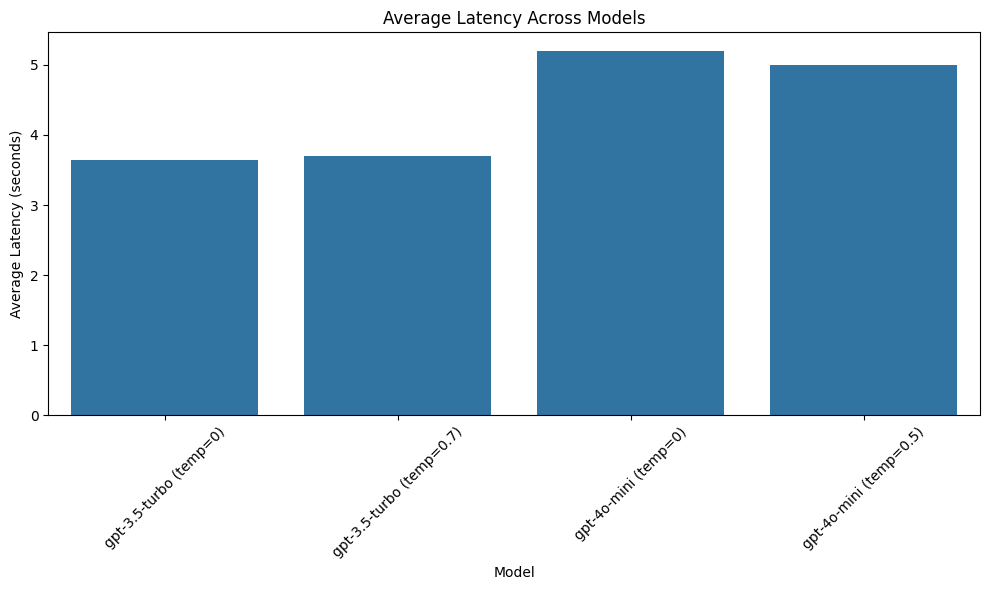

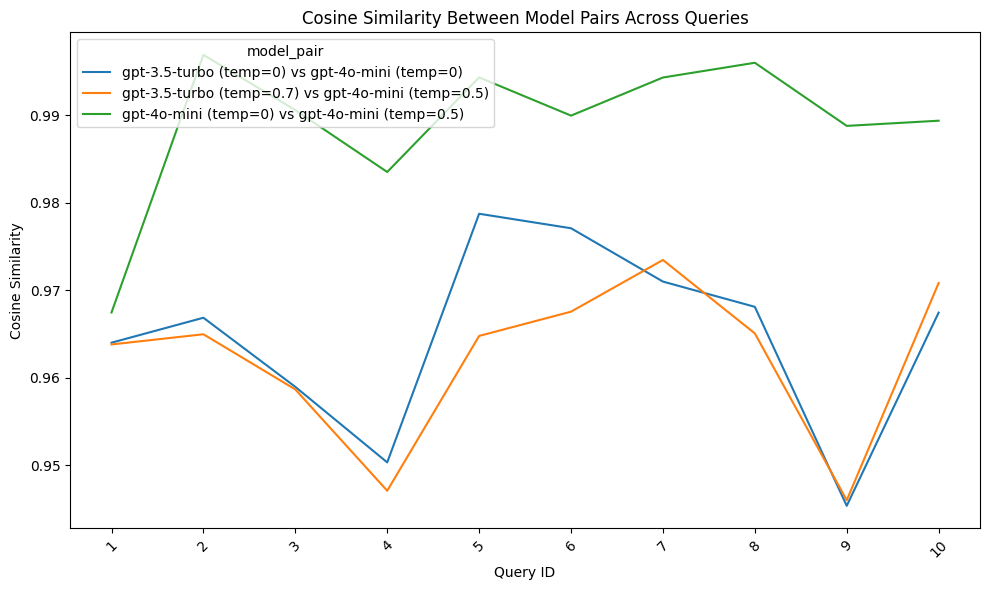

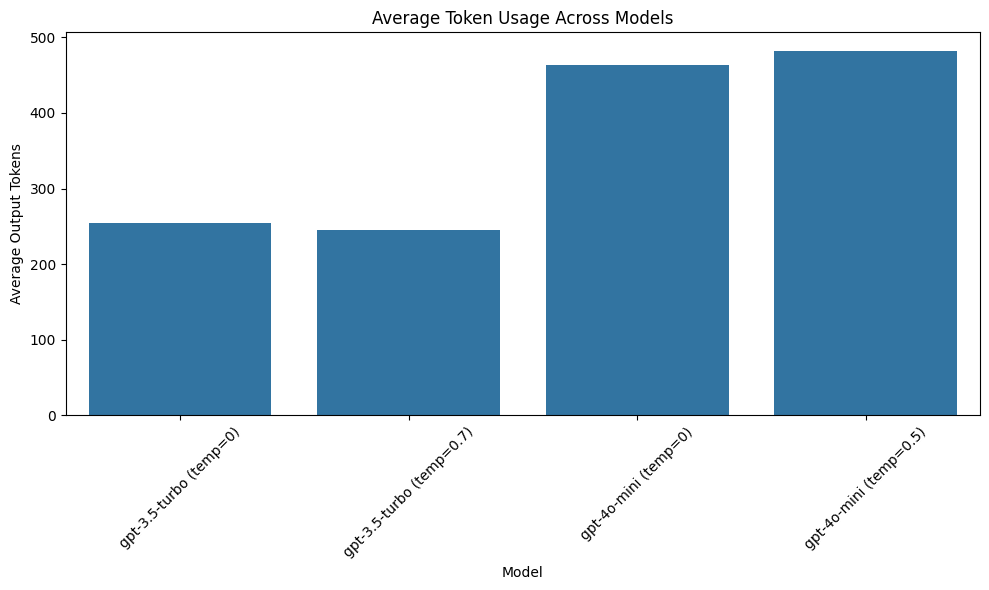

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_results contains your model evaluation results

# Step 1: Calculate Averages for Latency, Token Usage, and Cosine Similarity

# Latency Averages
average_latency_1 = df_results[['model_1', 'latency_1']].groupby('model_1').mean().reset_index()
average_latency_1.columns = ['model', 'avg_latency']
average_latency_2 = df_results[['model_2', 'latency_2']].groupby('model_2').mean().reset_index()
average_latency_2.columns = ['model', 'avg_latency']

# Combine the latency averages
average_latency = pd.concat([average_latency_1, average_latency_2]).groupby('model').mean().reset_index()

# Token Usage Averages
average_token_usage_1 = df_results[['model_1', 'output_tokens_1']].groupby('model_1').mean().reset_index()
average_token_usage_1.columns = ['model', 'avg_output_tokens']
average_token_usage_2 = df_results[['model_2', 'output_tokens_2']].groupby('model_2').mean().reset_index()
average_token_usage_2.columns = ['model', 'avg_output_tokens']

# Combine the token usage averages
average_token_usage = pd.concat([average_token_usage_1, average_token_usage_2]).groupby('model').mean().reset_index()

# Step 2: Reformat for Cosine Similarity

# Create a new DataFrame for each model pair comparison, including the new pair
df_model_pair = df_results[['query_id', 'model_1', 'model_2', 'cosine_similarity']].copy()

# Combine model_1 and model_2 to create unique model pairings
df_model_pair['model_pair'] = df_model_pair['model_1'] + ' vs ' + df_model_pair['model_2']

# Step 3: Plot the Results

# 1. Latency Across Models (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='avg_latency', data=average_latency)
plt.title('Average Latency Across Models')
plt.ylabel('Average Latency (seconds)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Cosine Similarity Across Queries (Line Chart for Model Pairs)
plt.figure(figsize=(10, 6))
sns.lineplot(x='query_id', y='cosine_similarity', hue='model_pair', data=df_model_pair)
plt.title('Cosine Similarity Between Model Pairs Across Queries')
plt.ylabel('Cosine Similarity')
plt.xlabel('Query ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Token Usage Across Models (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='avg_output_tokens', data=average_token_usage)
plt.title('Average Token Usage Across Models')
plt.ylabel('Average Output Tokens')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Human inspection of results of the 4 models

In [58]:
import os
import random
import re
from langchain.chains import create_retrieval_chain
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI

# Assuming postgres_retriever is already set up, as per your earlier code.

# Custom Prompt
CUSTOM_PROMPT = PromptTemplate(
    input_variables=["context", "input"],
    template="""
You are an AI assistant tasked with summarizing insights from mental health professionals about mental health related topics and issues.

## Provide an initial response that directly addresses the user's question or concern.
Use insights from the retrieved expert opinions to inform this response.

## After your initial response, provide a comprehensive summary, based only on the retrieved information, that:

## Based on what experts have said on topics relating to [summarized topic]
- [Provide a brief overview of the topic, including its definition and primary characteristics using only the retrieved documents]
- [List key aspects or identifiable features, if applicable. Only include information that is present in the retrieved documents]

## Key points regarding [summarized topic]
- Nature of the concept/issue: [Summarize the fundamental nature]
- Key aspects: [List main aspects or components]
- Related factors: [Summarize related factors or influences, if mentioned]
- Importance/Impact: [Outline the significance or effects]
- Professional perspectives: [Summarize expert views or approaches]

## Consensus among experts
- [Highlight any points of agreement among the experts]

## Specific insights or recommendations mentioned
- [List specific insights, advice, or recommendations given by experts, using bullet points]

Only include information that is present in the retrieved documents. Do not add any information from your own knowledge. 
If any section is not applicable based on the retrieved information, omit it from the summary. Ensure that bullet points are used consistently throughout the response.


Retrieved information:
{context}

User's question: {input}

Your summarized response:
"""
)

# Create the document chain
document_chain = create_retrieval_chain(postgres_retriever, CUSTOM_PROMPT)

# Function to process and format the RAG output
def post_process_rag_output(rag_output):
    answer = rag_output.get('answer', 'No answer found')
    sections = re.split(r'\n\d+\.|\n•', answer)
    sections = [section.strip() for section in sections if section.strip()]
    
    formatted_sections = []
    for section in sections:
        lines = section.split('\n')
        title = lines[0].strip(':')
        content = '\n'.join(lines[1:])
        formatted_sections.append(f"## {title}\n{content}\n")
    
    return "\n".join(formatted_sections)

# Function to run the RAG model
def run_rag(query):
    response = rag_chain.invoke({"input": query})
    formatted_response = post_process_rag_output(response)
    return formatted_response

# Queries to test
queries = [
    "How can I get over my posttraumatic stress disorder without my parents knowing about it?",
    "What is PTSD?",
    "hi",
    "Ciao",
    "You're the best",
    "I feel depressed?",
    "What is mental health",
    "What is depression",
    "What is a Tesla?",
    "I have so many issues to address. I have a history of sexual abuse, I'm a breast cancer survivor and I am a lifetime insomniac."
]

# Set up models
models = {
    "gpt-3.5-turbo (temp=0)": ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0),
    "gpt-3.5-turbo (temp=0.7)": ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7),
    "gpt-4o-mini (temp=0)": ChatOpenAI(model_name="gpt-4o-mini", temperature=0),
    "gpt-4o-mini (temp=0.5)": ChatOpenAI(model_name="gpt-4o-mini", temperature=0.5)
}

# Function to run all models on the list of queries and print the results
def run_models_and_display_results(models, queries):
    """Runs all models on each query and prints the results for comparison."""
    for idx, query in enumerate(queries):
        print(f"Query {idx + 1}: {query}")
        print("=" * 50)
        
        # Iterate over each model
        for model_name, model in models.items():
            print(f"Running model: {model_name}")
            response = run_rag(query)  # Run the model using run_rag
            print(f"{model_name}: {response}")
            print("\n")
        
        print("=" * 50)

# Run the function
run_models_and_display_results(models, queries)


Query 1: How can I get over my posttraumatic stress disorder without my parents knowing about it?
Running model: gpt-3.5-turbo (temp=0)
gpt-3.5-turbo (temp=0): ## Overcoming posttraumatic stress disorder (PTSD) without your parents knowing is certainly a challenge, but it is possible. The most important step is to seek professional help from a counselor, therapist, or psychologist who specializes in trauma. They can provide you with effective coping strategies and therapeutic techniques, such as Trauma-Focused Cognitive Behavioral Therapy, EMDR, or mindfulness practices, which can help you manage your symptoms. Additionally, engaging in creative therapies or journaling can be beneficial for processing your experiences. Remember, you don't need to share your trauma details with everyone; simply asking for a referral to a mental health professional is a good starting point. It's crucial to prioritize your mental health and find support that feels safe for you.

## Comprehensive Summary

